# ***Import Libarys***

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet import ResNet101
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications import InceptionResNetV2

import random
import os
import warnings
warnings.filterwarnings('ignore')
print('compelet')

compelet


# ***Data understanding & Visualizatio***

In [4]:
image_shape = (224,224)
batch_size = 64

train_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

# apply scaling only becouse data already augmented
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# load training data
print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

# load validation data (20% of training data)
print("Validating Images:")
valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

# load test data (consider validation data as test data)
print('Test Images:')
test_data = test_datagen.flow_from_directory(valid_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)


Training Images:
Found 56251 images belonging to 38 classes.
Validating Images:
Found 14044 images belonging to 38 classes.
Test Images:
Found 17572 images belonging to 38 classes.


***From previous cell we know that we have 38 class***
> * 56251 images in train data
> * 14044 images in valisation data
> * 17572 images in test data
> * 33 imgeas in test data (the label of test data is the name of image) we will uses them to predict later

***But what are 38 classes ?!***

In [5]:
# show how data store 
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')
print(f'label  \n{labels[0]}')

shape of image is : (224, 224, 3)
label  
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
# show all diseases in dataset
diseases = os.listdir(train_dir)
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

***We notice that we have the same plant in different class such as:***
 > * Tomato___Early_blight
 > * Tomato___Late_blight
 > * Tomato___healthy
 > * ...

***so we need to know what is the different type of plant we have***

In [7]:
# identify uniqe plant in dataset
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :14
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


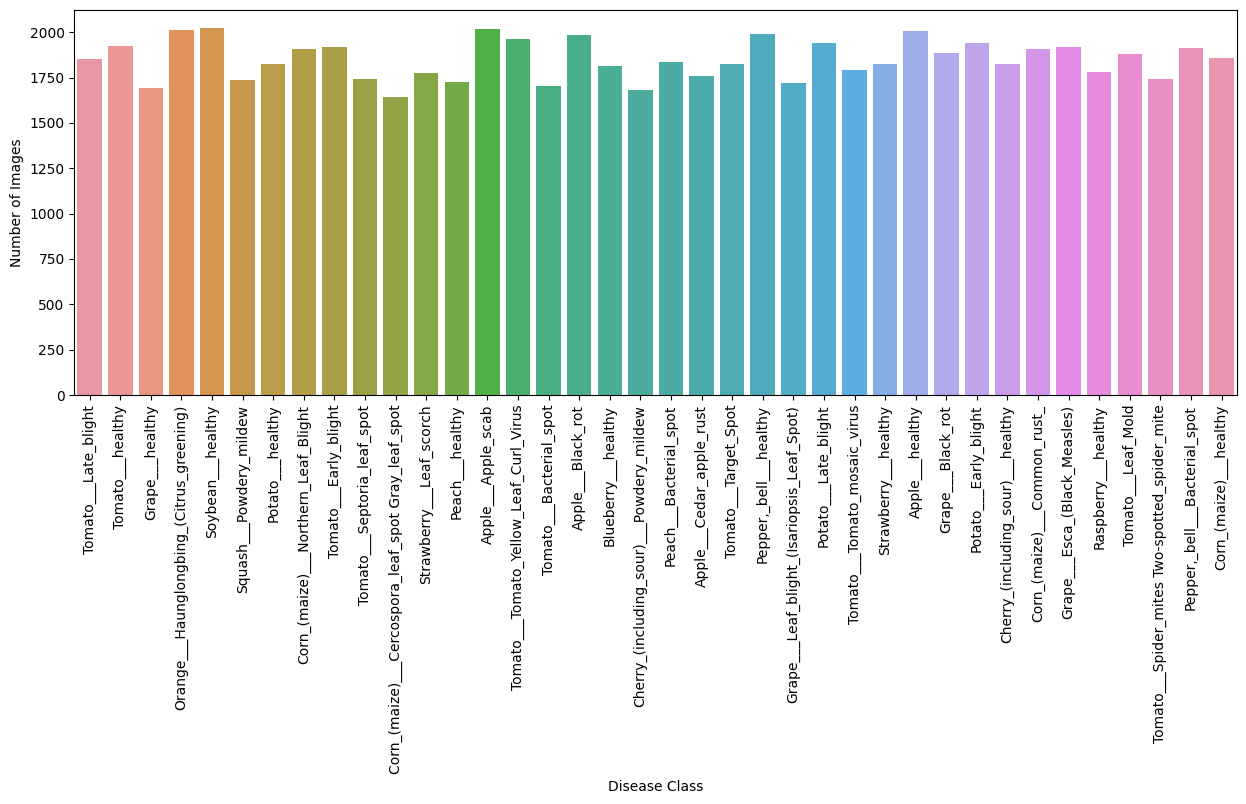

In [8]:
# show number of each class
dic = {}
for Class in diseases:
    dic[Class] = len(os.listdir(train_dir + '/' + Class))

df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

# df = df.sort_values(by="Number of Images", ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=df ,x='Disease Class' ,y= 'Number of Images' )
plt.xticks(rotation=90)
plt.show()

***As we notice that classes are somewhat balanced***

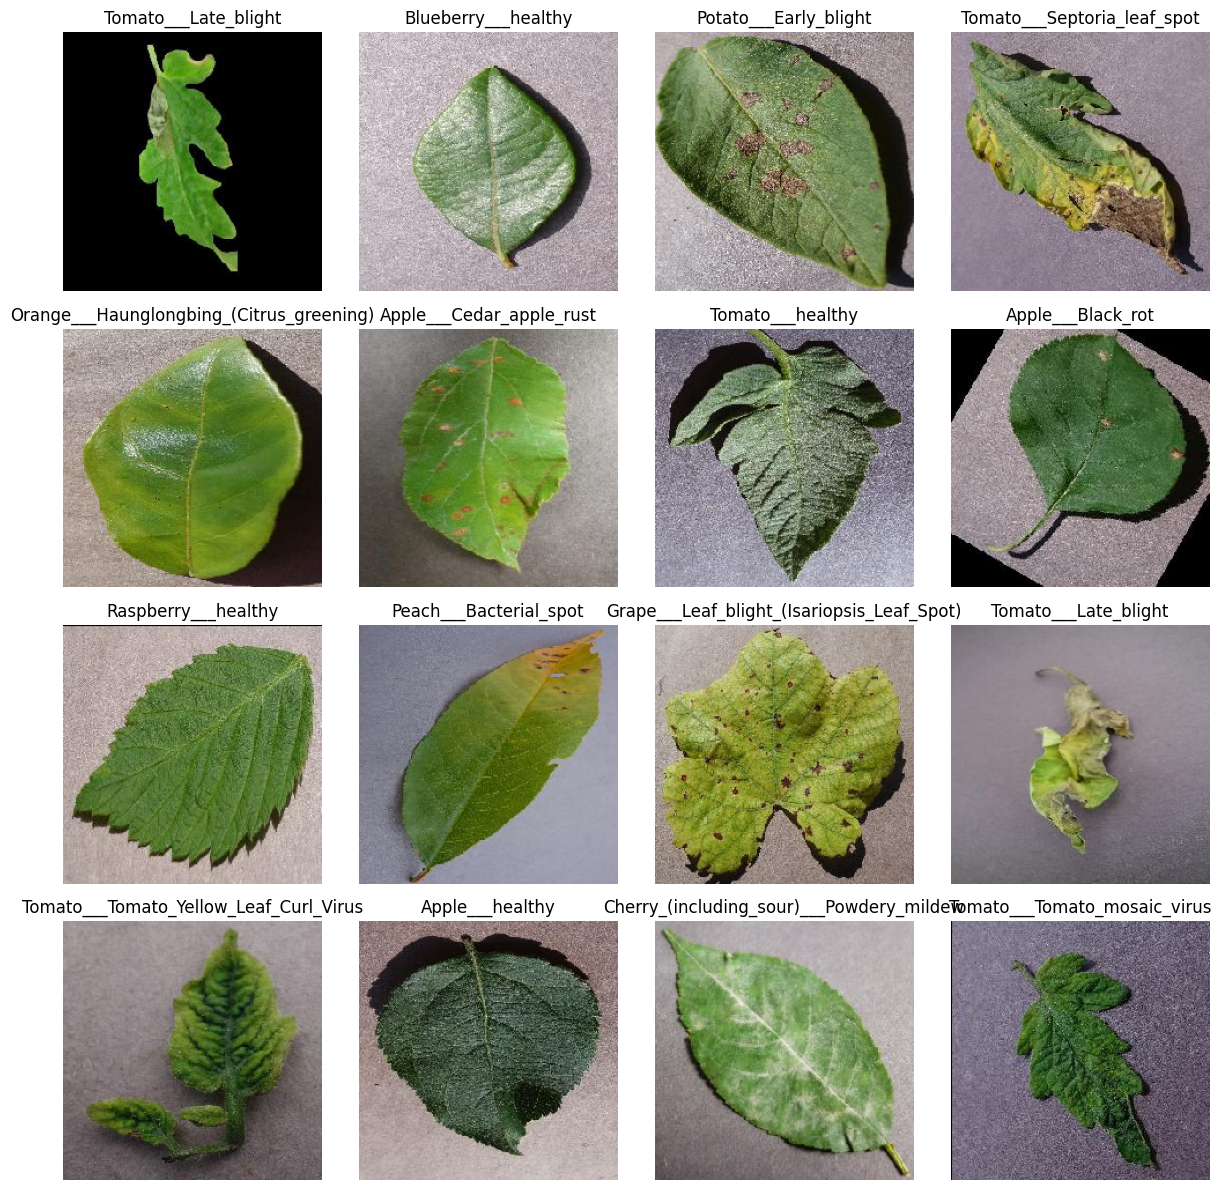

In [9]:
import random
# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])  
    plt.axis("off")  

plt.tight_layout()
plt.show()


# ***Modeling***

***Function will be used***

Learning curve function
> * learning curve
> * loss curve

In [10]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


Prediction function
> Compare Truth label (name of image ) with predicted label

In [11]:
def predict_labels_and_display(model_path, test_dir='/kaggle/input/new-plant-diseases-dataset/test/test', image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')): 
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label (name of image)
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# ***CNN Model***

In [12]:
# Model Architecture
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'elu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

In [13]:
# train the model
model_checkpoint = ModelCheckpoint('/kaggle/working/cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=10,
                    batch_size=64, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/10


I0000 00:00:1736133411.031203     136 service.cc:145] XLA service 0x7ad43800e9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736133411.031273     136 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1736133411.031280     136 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1736133437.654506     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.3453 - loss: 2.3382
Epoch 1: val_accuracy improved from -inf to 0.70436, saving model to /kaggle/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 616s 662ms/step - accuracy: 0.3455 - loss: 2.3375 - val_accuracy: 0.7044 - val_loss: 0.9432
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7565 - loss: 0.7986
Epoch 2: val_accuracy improved from 0.70436 to 0.82704, saving model to /kaggle/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 251s 283ms/step - accuracy: 0.7565 - loss: 0.7985 - val_accuracy: 0.8270 - val_loss: 0.5474
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8566 - loss: 0.4603
Epoch 3: val_accuracy improved from 0.82704 to 0.91605, saving model to /kaggle/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 253s 286ms/step - accuracy: 0.8566 - loss: 0.4603 - val_accuracy: 0.9160 - val_loss: 0.2679
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8912 - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9196 - loss: 0.2501
Epoch 5: val_accuracy did not improve from 0.92474
879/879 ━━━━━━━━━━━━━━━━━━━━ 253s 285ms/step - accuracy: 0.9196 - loss: 0.2501 - val_accuracy: 0.8378 - val_loss: 0.5204
Epoch 6/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9339 - loss: 0.2062
Epoch 6: val_accuracy did not improve from 0.92474
879/879 ━━━━━━━━━━━━━━━━━━━━ 249s 282ms/step - accuracy: 0.9339 - loss: 0.2061 - val_accuracy: 0.9135 - val_loss: 0.2610
Epoch 7/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9426 - loss: 0.1797
Epoch 7: val_accuracy improved from 0.92474 to 0.94275, saving model to /kaggle/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 249s 282ms/step - accuracy: 0.9426 - loss: 0.1797 - val_accuracy: 0.9428 - val_loss: 0.1745
Epoch 8/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9529 - loss: 0.1437
Epoch 8: val_accuracy improved from 0.94275 to 0.96326, saving model to /kaggle/working/cn

In [14]:
# # save model to use later
model.save('/kaggle/working/cnn_model.keras')


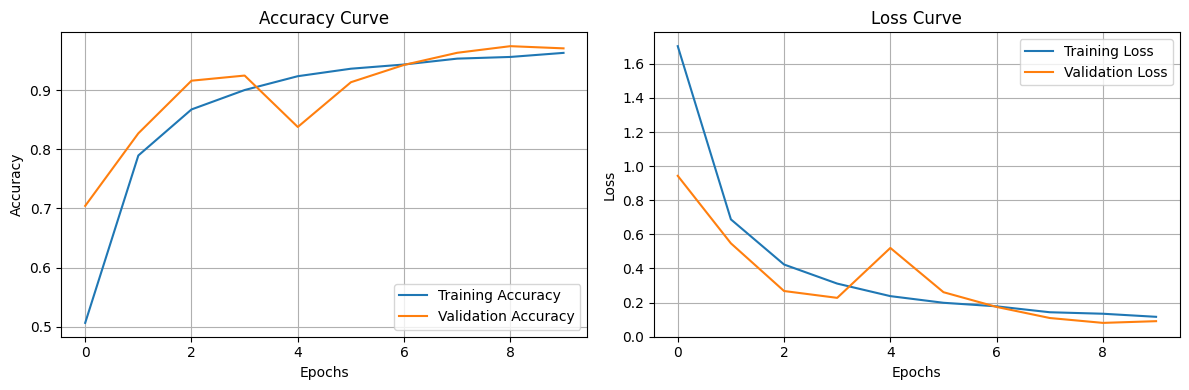

In [15]:
# show learning curves
plot_learning_curves(history)

In [16]:
# showe accuracy on test data (model evaluation)
best_model = load_model('/kaggle/working/cnn_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 164s 592ms/step - accuracy: 0.9826 - loss: 0.0557
Test Loss: 0.0754
Test Accuracy: 0.9774


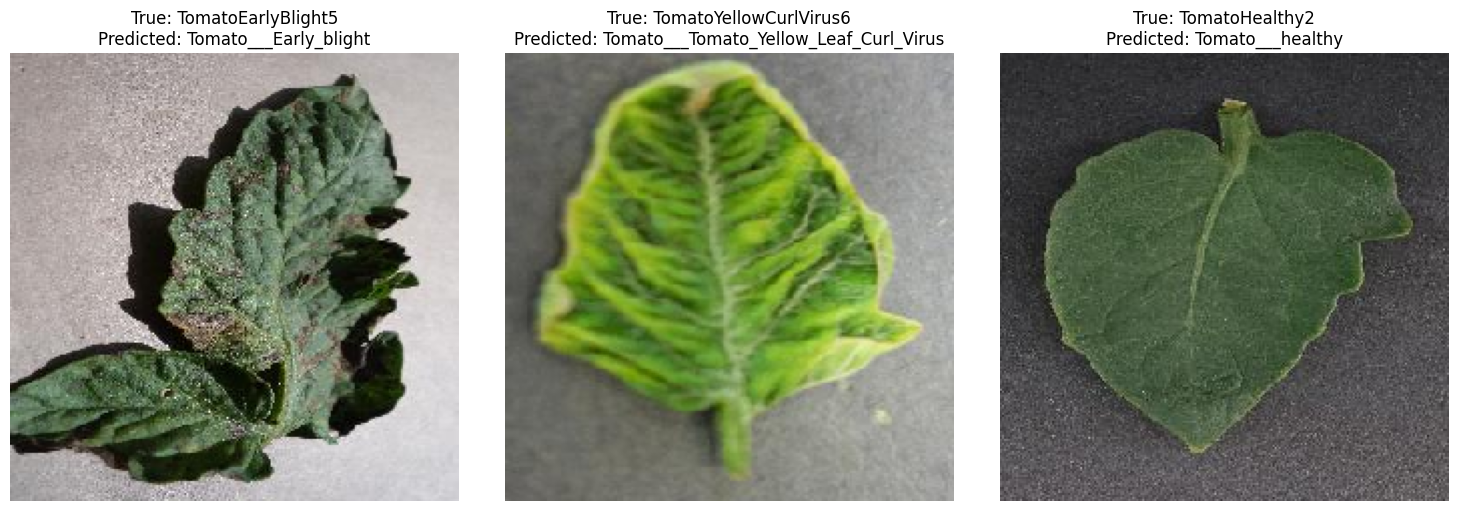

In [17]:
# show random sample of prediction of model on test data
predict_labels_and_display('/kaggle/working/cnn_model.keras')

***Notice that accuracy on CNN model is :***
>* traning accueacy : 0.9233
>* validation accuracy: 0.9426
>* test accuracy : 0.9432

***soo let's try pretrained model***

# ***ResNet50***

In [18]:
# call resnet50 from keres 
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# iterate through its layers and frezzing them
for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Model architecure
last_output = resnet.output

x = GlobalAveragePooling2D()(last_output)

x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

x = Dense(38, activation='softmax')(x)

resnet_model = Model(inputs=resnet.input, outputs=x)

# opt = Adam(learning_rate=0.0001)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
# resnet_model.summary()

In [21]:
model_checkpoint = ModelCheckpoint('/kaggle/working/resnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

history =resnet_model.fit(train_data,
                        validation_data=valid_data,
                        epochs=100,  
                        batch_size=64, 
                        callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.0397 - loss: 3.5501
Epoch 1: val_accuracy improved from -inf to 0.07861, saving model to /kaggle/working/resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 219s 229ms/step - accuracy: 0.0397 - loss: 3.5499 - val_accuracy: 0.0786 - val_loss: 3.2008
Epoch 2/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.0929 - loss: 3.1534
Epoch 2: val_accuracy improved from 0.07861 to 0.16470, saving model to /kaggle/working/resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 185s 209ms/step - accuracy: 0.0929 - loss: 3.1533 - val_accuracy: 0.1647 - val_loss: 2.8811
Epoch 3/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.1551 - loss: 2.8894
Epoch 3: val_accuracy improved from 0.16470 to 0.19667, saving model to /kaggle/working/resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 182s 206ms/step - accuracy: 0.1551 - loss: 2.8893 - val_accuracy: 0.1967 - val_loss: 2.7438
Epoch 4/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/st

In [22]:
# # save model to use later
model.save('/kaggle/working/resnet_model.keras')


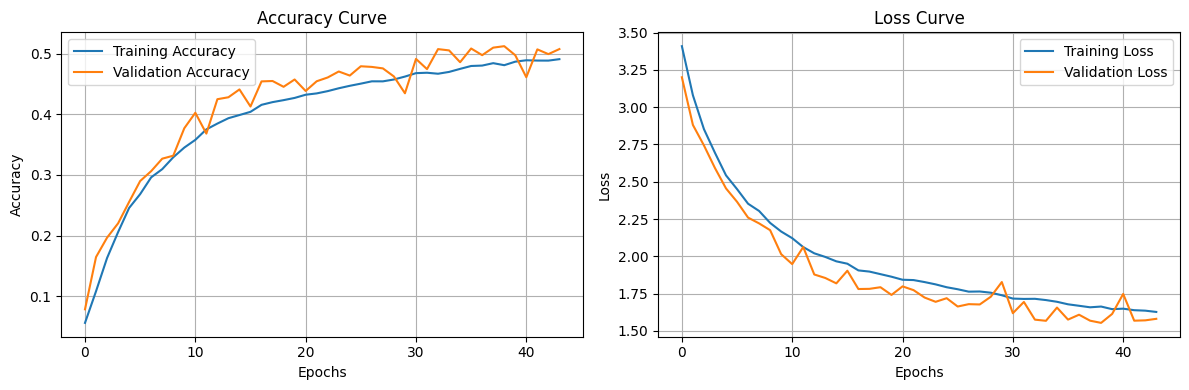

In [23]:
# show learning curves
plot_learning_curves(history)

In [24]:
# showe accuracy on test data
best_model = load_model('/kaggle/working/resnet_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 180ms/step - accuracy: 0.9826 - loss: 0.0557
Test Loss: 0.0754
Test Accuracy: 0.9774


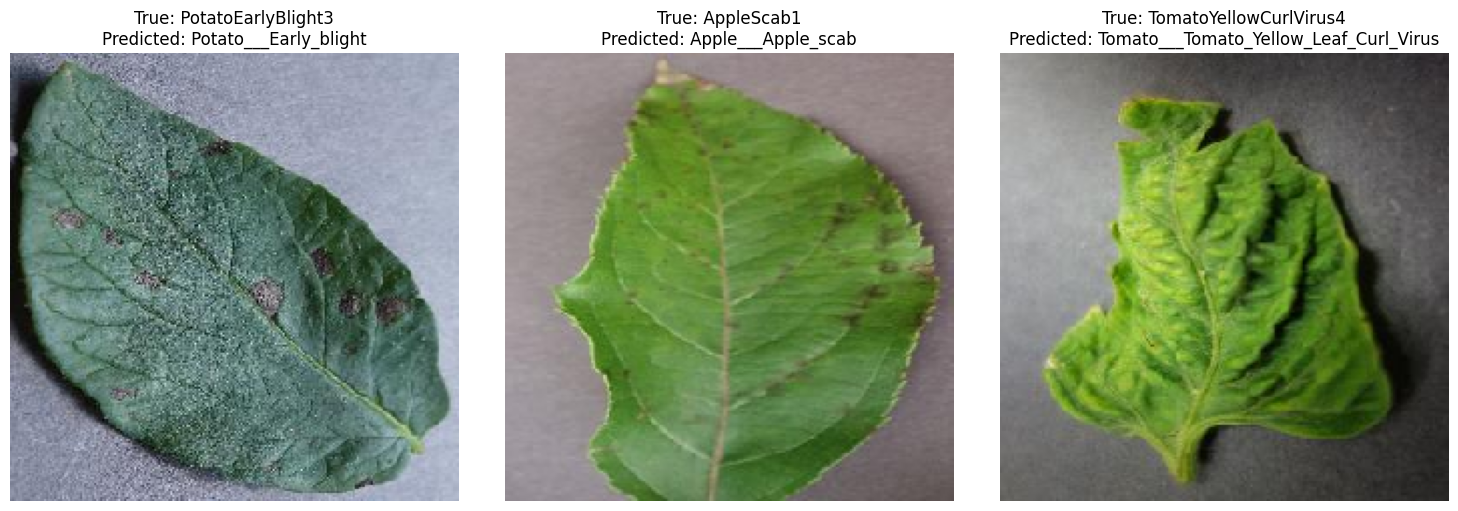

In [25]:
# show random sample of prediction of model on test data
predict_labels_and_display('/kaggle/working/resnet_model.keras')

***Notice that accuracy on ResNet50 model is :***
>* traning accueacy : 0.5208 
>* validation accuracy: 0.5471
>* test accuracy : 0.5520

***We need to improve this accuracy soo let's try another pretrained model***


# ***inception Model***

In [28]:
inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in inception_resnet.layers:
    layer.trainable = False


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
last_output = inception_resnet.output

x = GlobalAveragePooling2D()(last_output)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(38, activation='softmax')(x)  

inception_resnet_model = Model(inputs=inception_resnet.input, outputs=x)

inception_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
model_checkpoint = ModelCheckpoint('/kaggle/working/inception_resnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001)

history =inception_resnet_model.fit(train_data,
                                    validation_data=valid_data,
                                    epochs=20,  
                                    batch_size=64, 
                                    callbacks=[model_checkpoint, early_stopping, model_ReduceLROnPlateau])

Epoch 1/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7036 - loss: 1.0367
Epoch 1: val_accuracy improved from -inf to 0.82106, saving model to /kaggle/working/inception_resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 374s 384ms/step - accuracy: 0.7037 - loss: 1.0363 - val_accuracy: 0.8211 - val_loss: 0.5587 - learning_rate: 0.0010
Epoch 2/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8829 - loss: 0.3532
Epoch 2: val_accuracy improved from 0.82106 to 0.88864, saving model to /kaggle/working/inception_resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 302s 341ms/step - accuracy: 0.8829 - loss: 0.3531 - val_accuracy: 0.8886 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 3/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9038 - loss: 0.2911
Epoch 3: val_accuracy did not improve from 0.88864
879/879 ━━━━━━━━━━━━━━━━━━━━ 299s 339ms/step - accuracy: 0.9038 - loss: 0.2911 - val_accuracy: 0.8572 - val_loss: 0.4550 - learning_rate: 0.0010
Epoch 4/20
879/879 

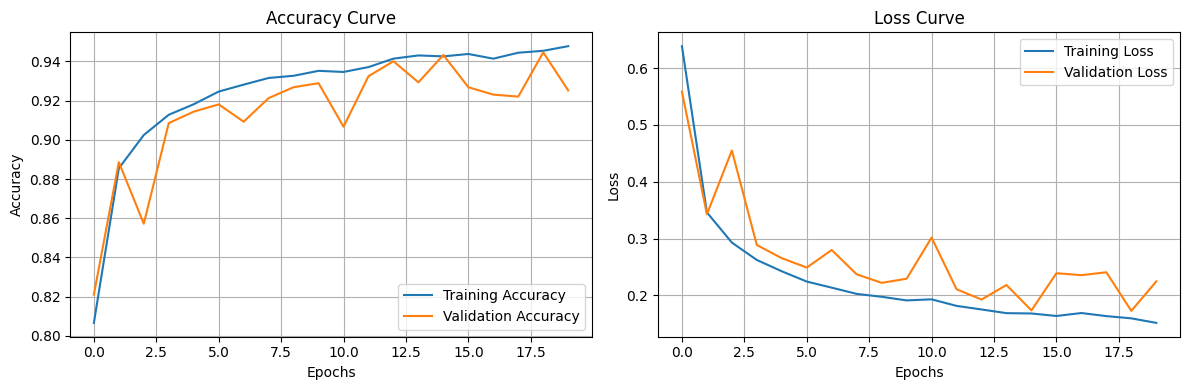

In [31]:
# show learning curves
plot_learning_curves(history)

In [34]:
# showe accuracy on test data
best_model = load_model('/kaggle/working/inception_resnet_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 91s 283ms/step - accuracy: 0.9692 - loss: 0.0932
Test Loss: 0.1447
Test Accuracy: 0.9527


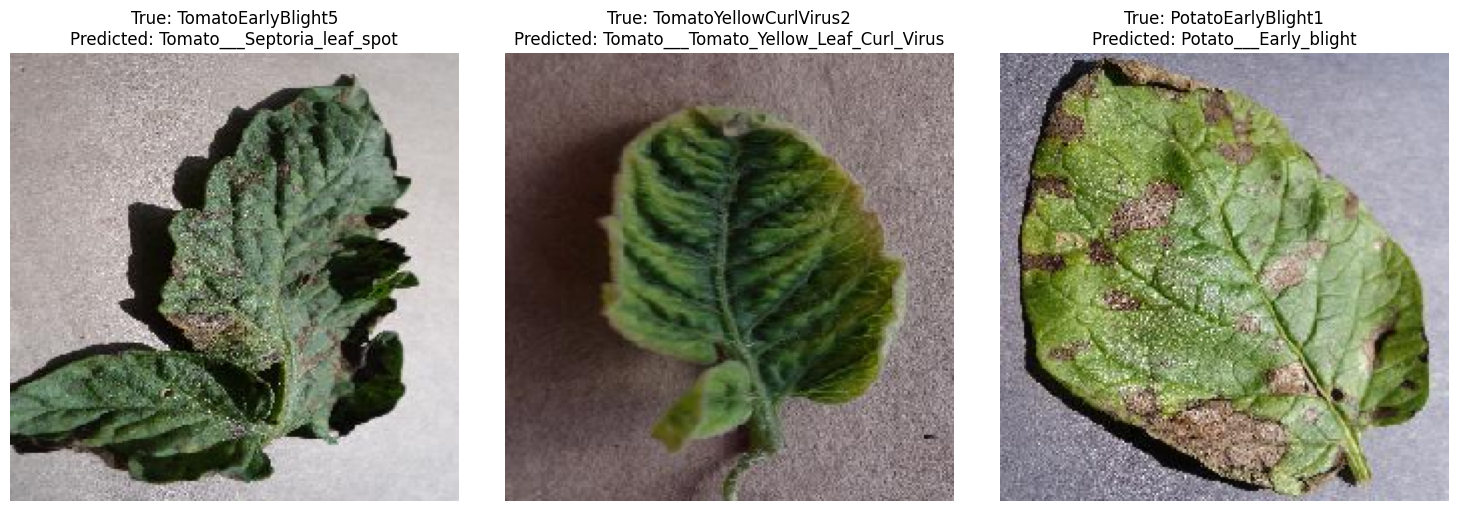

In [35]:
# show random sample of prediction of model on test data
predict_labels_and_display('/kaggle/working/inception_resnet_model.keras')

***Notice that accuracy on inception_resnet  model is :***
>* traning accueacy : 0.9412
>* validation accuracy: 0.940
>* test accuracy : 0.9467

***soo let's try another pretrained model to increase the accuracy***

# ***Vgg_16 Model***

In [36]:
# use VGG16 from Keres
vgg_16 = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))

# iterate through its layers and frezzing them expect the last block (last 5 layers)
for layer in vgg_16.layers[:-5]:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
# take the last layer from VGG16 and link it with my fully connected layer
last_output = vgg_16.output

# take the last layer from VGG16 and link it with my fully connected layer
x = GlobalAveragePooling2D()(last_output)

x = Dense(256, activation='elu', kernel_initializer=GlorotNormal())(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='elu', kernel_initializer=GlorotNormal())(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='elu', kernel_initializer=GlorotNormal())(x)
x = BatchNormalization()(x)


x = Dense(38, activation='softmax')(x)


vgg_model = Model(inputs=vgg_16.input, outputs=x)

vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "functional_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,930,982 (56.96 MB)

 Trainable params: 7,295,590 (27.83 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [38]:
# train the model
model_checkpoint = ModelCheckpoint('/kaggle/working/vgg_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history =vgg_model.fit(train_data,
                        validation_data=valid_data,
                        epochs=10,  
                        batch_size=64, 
                        callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6078 - loss: 1.4556
Epoch 1: val_accuracy improved from -inf to 0.88429, saving model to /kaggle/working/vgg_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 373s 391ms/step - accuracy: 0.6080 - loss: 1.4548 - val_accuracy: 0.8843 - val_loss: 0.3689
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9420 - loss: 0.1864
Epoch 2: val_accuracy improved from 0.88429 to 0.93264, saving model to /kaggle/working/vgg_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 306s 347ms/step - accuracy: 0.9420 - loss: 0.1864 - val_accuracy: 0.9326 - val_loss: 0.2193
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9658 - loss: 0.1133
Epoch 3: val_accuracy improved from 0.93264 to 0.93385, saving model to /kaggle/working/vgg_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 306s 347ms/step - accuracy: 0.9658 - loss: 0.1133 - val_accuracy: 0.9339 - val_loss: 0.2166
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy

In [39]:
# # save model to use later
model.save('/kaggle/working/vgg_model.keras')


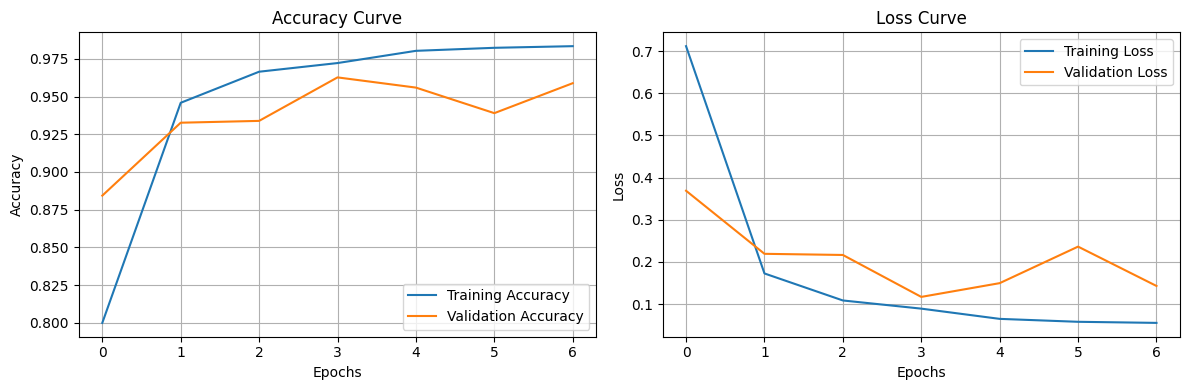

In [40]:
# show learning curves
plot_learning_curves(history)

In [41]:
# showe accuracy on test data
best_model = load_model('/kaggle/working/vgg_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 64s 229ms/step - accuracy: 0.9826 - loss: 0.0557
Test Loss: 0.0754
Test Accuracy: 0.9774


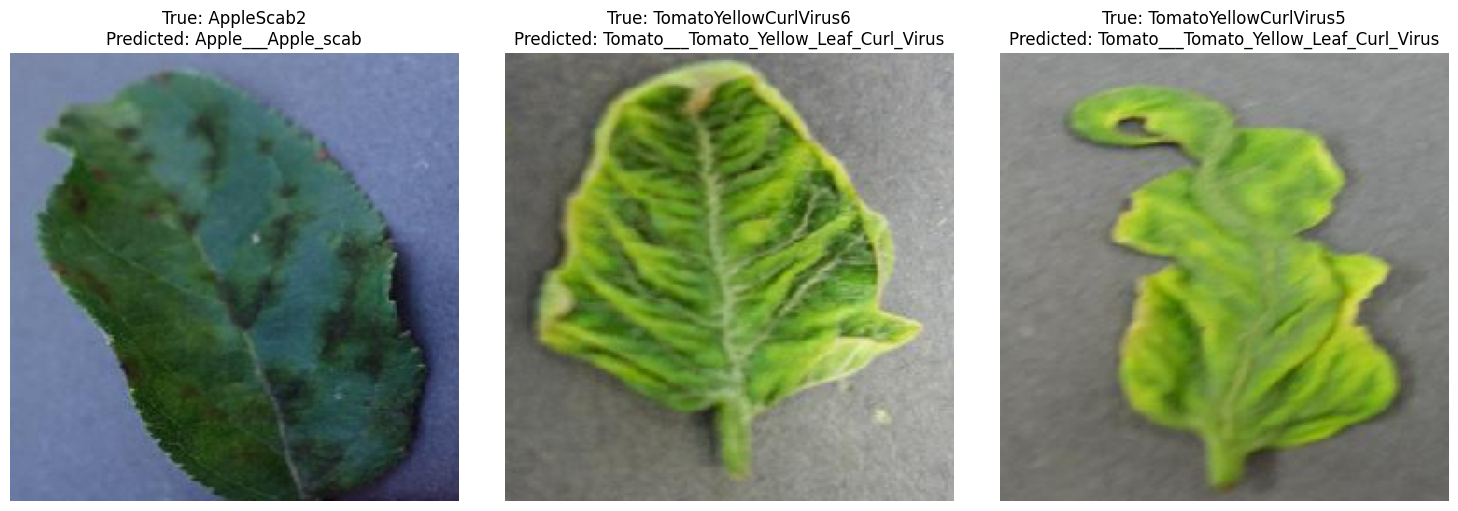

In [42]:
# show random sample of prediction of model on test data
predict_labels_and_display('/kaggle/working/vgg_model.keras')

***Notice that accuracy on VGG_16 model is :***
>* traning accueacy :0.9760
>* validation accuracy: 0.9628
>* test accuracy : 0.9652


# ***Classification report***

In [43]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model_path, test_data, model_name):
    # load model
    model = tf.keras.models.load_model(model_path)

    # predict
    y_pred = model.predict(test_data)
    y_pred_classes = y_pred.argmax(axis=1)

    # get true classes
    y_true = test_data.classes

    class_labels = list(test_data.class_indices.keys())

    accuracy = accuracy_score(y_true, y_pred_classes)

    report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

    df_report = pd.DataFrame(report).transpose()

    df_report.loc['accuracy'] = [accuracy, None, None, None]

    df_report['model'] = model_name

    return df_report

cnn_model_path = 'cnn_model.keras'
vgg_model_path = 'vgg_model.keras'
resnet_model_path = 'resnet_model.keras'
inception_resnet_path = 'inception_resnet_model.keras'


cnn_report = evaluate_model(cnn_model_path, test_data, 'CNN')
vgg_report = evaluate_model(vgg_model_path, test_data, 'VGG')
resnet_report = evaluate_model(resnet_model_path, test_data, 'ResNet')
inception_report = evaluate_model(inception_resnet_path, test_data, 'Inception_resnet')


all_reports = pd.concat([cnn_report, vgg_report, resnet_report ,inception_report])

all_reports = all_reports.reset_index().rename(columns={'index': 'metric'})

all_reports


275/275 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 46s 165ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 45s 162ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 90s 294ms/step


metric  precision    recall  f1-score  support  \
0              Apple___Apple_scab   0.984344  0.998016  0.991133    504.0   
1               Apple___Black_rot   0.990000  0.995976  0.992979    497.0   
2        Apple___Cedar_apple_rust   0.993135  0.986364  0.989738    440.0   
3                 Apple___healthy   0.991952  0.982072  0.986987    502.0   
4             Blueberry___healthy   0.989035  0.993392  0.991209    454.0   
..                            ...        ...       ...       ...      ...   
159  Tomato___Tomato_mosaic_virus   0.954853  0.944196  0.949495    448.0   
160              Tomato___healthy   0.920160  0.958420  0.938900    481.0   
161                      accuracy   0.952652       NaN       NaN      NaN   
162                     macro avg   0.953729  0.952349  0.952031  17572.0   
163                  weighted avg   0.953715  0.952652  0.952182  17572.0   

                model  
0                 CNN  
1                 CNN  
2                 CNN  
3                 CNN  
4                 CNN  
..                ...  
159  Inception_resnet  
160  Inception_resnet  
161  Inception_resnet  
162  Inception_resnet  
163  Inception_resnet  

[164 rows x 6 columns]

In [46]:
pd.set_option('display.max_rows', 123)

all_reports.to_csv('result.csv')

In [45]:
x =all_reports[all_reports['metric'] == 'macro avg']
x

metric  precision    recall  f1-score  support             model
39   macro avg   0.977943  0.977272  0.977272  17572.0               CNN
80   macro avg   0.977943  0.977272  0.977272  17572.0               VGG
121  macro avg   0.977943  0.977272  0.977272  17572.0            ResNet
162  macro avg   0.953729  0.952349  0.952031  17572.0  Inception_resnet